 **Helmet Detection Using Vision Transformers
 and Explainable AI: A Deep Learning Approach
 for Safety Compliance**

Kiran Koushika Raja

Msc Data Analytics

Student Id- 24241163

Data Exploration

In [225]:
# Mounting my Drive to the google colab to access the Dataset
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [226]:
#Setting up the paths for the Dataset, Images and Annotations folder from the Drive
Path_from_drive = "/content/drive/MyDrive/Thesis/thesis dataset final/Dataset"
Images_JPG_folder = "/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/JPEGImages"
Annotations_xml_folder = "/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/Annotations"

In [227]:
#Importing all the necessary libraries and packages
import cv2
import glob
import random
import xml.etree.ElementTree as etre
import matplotlib.pyplot as plt
import re
import os
from tqdm import tqdm
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
import json
from pathlib import Path
from datasets import Dataset
from torch.utils.data import Dataset
from PIL import Image
import torch
from transformers import Trainer, TrainingArguments

In [230]:
# installing the transformers package
!pip install transformers datasets torchvision

In [231]:
!pip install -U transformers

In [232]:
# Getting and storing all the image paths of the images as a list
# Making sure no images are left due to case sensitivity
image_count=glob.glob(f"{Images_JPG_folder}/*.[jJ][pP][gG]")
image_count[:5]

['/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/JPEGImages/PartB_01352.jpg',
 '/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/JPEGImages/PartB_01383.jpg',
 '/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/JPEGImages/PartB_01366.jpg',
 '/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/JPEGImages/PartB_01382.jpg',
 '/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/JPEGImages/PartB_01351.jpg']

In [233]:
len(image_count)

7581

In [234]:
# Removing one duplicate entry image
duplicate_file = os.path.join(Images_JPG_folder, "PartB_01709 (1).jpg")
if os.path.exists(duplicate_file):
    os.remove(duplicate_file)

In [235]:
# Creates a dictionary that will map the path and image names as key and value pairs
image_path_map = {}
for image1 in image_count:
 imgname = image1.split("/")[-1].split(".")[0]
 image_path_map[imgname] = image1


In [236]:
print(image_path_map["part2_000069"])

/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/JPEGImages/part2_000069.jpg


In [237]:
# Calculating and storing the height and width of each mage in the dataset
image_heights = []
image_widths = []
for paths_all in image_count:
 shape = cv2.imread(paths_all).shape # Read the images from all the paths and find its height and width
 height, width = shape[0], shape[1]
 image_heights.append(height)
 image_widths.append(width)
# Printing the dimensions of few images
print("Dimensions of the images:",list(zip(image_heights[:3],image_widths[:3])))

Dimensions of the images: [(450, 600), (1146, 1727), (293, 420)]


In [238]:
# Extracting the count of the images with "helmet" and "no helmet" by the names of the files
all_files = os.listdir(Images_JPG_folder)
PartA_images = [images for images in all_files if images.lower().startswith("parta_") and images.lower().endswith('.jpg')]
PartB_images = [images for images in all_files if images.lower().startswith("partb_") and images.lower().endswith('.jpg')]
Part2_images = [images for images in all_files if images.lower().startswith("part2_") and images.lower().endswith('.jpg')]
number_only_images = [] # Getting the remaining file names which are only numbers
for x in all_files:
 img_name, img_extension = os.path.splitext(x)
 if img_extension.lower() == '.jpg' and re.fullmatch(r'\d+', img_name):
  number_only_images.append(x)
helmet_images = Part2_images + number_only_images
# Printing the number of images in each class to show class distribution
print("CCTV Images (PartA):", len(PartA_images))
print("Public & University Images (PartB):", len(PartB_images))
print("Helmet Wearing Individuals (Part2 + numbered images):", len(helmet_images))
Total_Images=PartA_images+PartB_images+helmet_images
print("The Total Images :",len(Total_Images))

CCTV Images (PartA): 1999
Public & University Images (PartB): 2341
Helmet Wearing Individuals (Part2 + numbered images): 3241
The Total Images : 7581


In [239]:
len(helmet_images)

3241

In [240]:
# Function to read the data like the labels and he bounding box values from the annotations file
def read_boundingbox_annotation(xml_file: str):
 tree = etre.parse(xml_file)
 root = tree.getroot()
 annotation_filename = root.find('filename').text
 bounding_boxes = []
 labels = []
 for obj in root.findall('object'):
   label = obj.find('name').text
   bbox = obj.find('bndbox')
   xmin, ymin, xmax, ymax = [int(bbox.find(tag).text) for tag in ("xmin", "ymin", "xmax", "ymax")]
   bounding_boxes.append([xmin, ymin, xmax, ymax])
   labels.append(label)
 return annotation_filename, bounding_boxes, labels

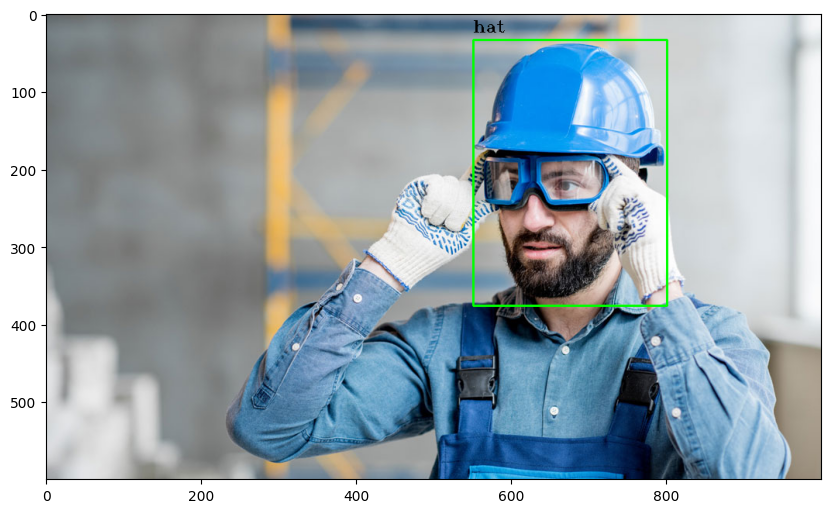

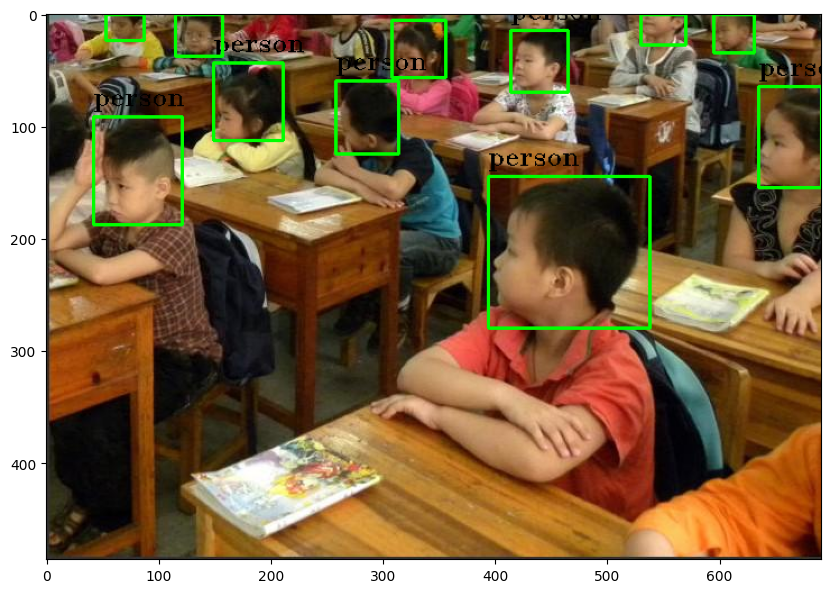

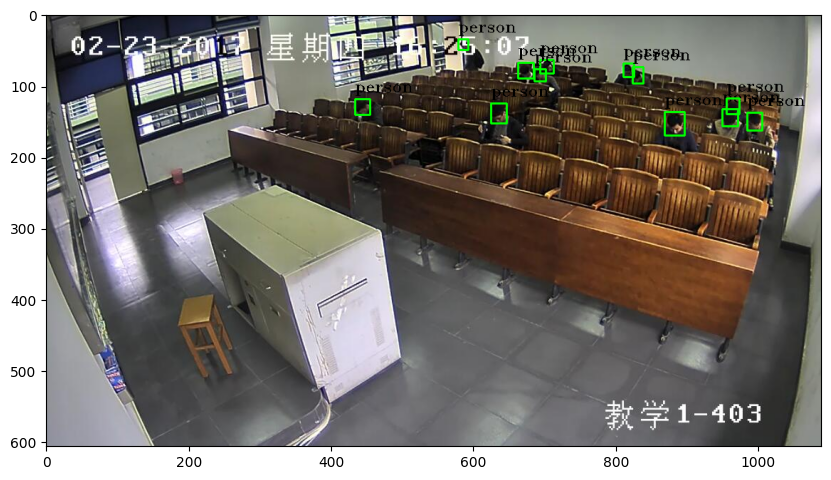

In [241]:
# Printing the Ground Truth bounding box values on the images
def label_specific_format(image1,label,x,y):
 cv2.putText(image1,label,(x,y),fontFace=cv2.FONT_HERSHEY_TRIPLEX,fontScale=0.7,color=(0,0,0))
def image_with_box_groundT(image_path, boxes, labels):
 image1 = cv2.imread(image_path)
 for bounding_box, label in zip(boxes, labels):
  xmin, ymin, xmax, ymax = bounding_box
  right=(xmin,ymin)
  left=(xmax,ymax)
  cv2.rectangle(image1, right, left, (0,255,0), 2),label_specific_format(image1,label,xmin,ymin-10), # Print the labels also
 image_to_RGB = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
 plt.figure(figsize=(10, 8))
 plt.imshow(image_to_RGB)
 plt.show()
img1 = "part2_000067"
img2="PartB_01268"
img3="PartA_00543"
xml_path1 = os.path.join(Annotations_xml_folder,img1 + ".xml")
image_path1 = os.path.join(Images_JPG_folder,img1 + ".jpg")
xml_path2 = os.path.join(Annotations_xml_folder,img2 + ".xml")
image_path2 = os.path.join(Images_JPG_folder,img2 + ".jpg")
xml_path3 = os.path.join(Annotations_xml_folder,img3 + ".xml")
image_path3 = os.path.join(Images_JPG_folder,img3 + ".jpg")
fname,boxes,labels = read_boundingbox_annotation(xml_path1)
image_with_box_groundT(image_path1,boxes,labels)
fname,boxes,labels = read_boundingbox_annotation(xml_path2)
image_with_box_groundT(image_path2,boxes,labels)
fname,boxes,labels = read_boundingbox_annotation(xml_path3)
image_with_box_groundT(image_path3,boxes,labels)

In [242]:
# Function to read the text files containing the image names that belong to test, train and validation set
def read_text_split_file(file_path_text):
 with open(file_path_text, 'r') as text:
  lines=text.read().splitlines()
 return lines
# Path of the text files needed to be read
train_text_path="/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/ImageSets/Main/train.txt"
validation_text_path="/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/ImageSets/Main/val.txt"
test_text_path="/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/ImageSets/Main/test.txt"

train_list=read_text_split_file(train_text_path)
validation_list=read_text_split_file(validation_text_path)
test_list=read_text_split_file(test_text_path)

**Convert PASCAL VOC XML to COCO format**

In [243]:
# Output folder path is set
output_coco_file = "/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/COCO_new"
os.makedirs(output_coco_file, exist_ok=True)
image_files = []
for image in ("*.jpg","*.jpeg","*.JPEG","*.png","*.PNG","*.JPG"):
 image_files.extend(glob.glob(os.path.join(Images_JPG_folder, image)))
image_path_map = {Path(image1).stem: image1 for image1 in image_files}
categories = [{"id": 0,"name": "with helmet"},{"id": 1, "name": "without helmet"}] # Defining the Class and label mapping
label_map = {"hat": 0,"person": 1}

In [244]:
# Function to convert Pascal VOC XMl file to COCO format json file
def convert_pascal_to_coco(split_list, output_file):
    images, annotations = [], []
    annotation_id = 0
    for img_id, image_id in enumerate(tqdm(split_list)):
        xml_file = os.path.join(Annotations_xml_folder, image_id + ".xml")
        image_path = image_path_map.get(image_id)
        if not image_path or not os.path.exists(xml_file): # continue skip if that image or annotation file is not available
            continue
        filename, bounding_boxes, labels = read_boundingbox_annotation(xml_file)
        image1 = cv2.imread(image_path)
        height, width = image1.shape[:2]
        images.append({"id": img_id,"file_name": os.path.basename(image_path),"width": width,
            "height": height}) # Adding the information of the image needed as list

        for bounding_box, label in zip(bounding_boxes, labels):
            xmin, ymin, xmax, ymax = bounding_box
            w1, h1 = xmax - xmin, ymax - ymin
            if label not in label_map or w1 <= 0 or h1 <= 0:
                continue
            annotations.append({"id": annotation_id,
                "image_id": img_id,
                "category_id": label_map[label],
                "bbox": [xmin, ymin, w1, h1],
                "area": w1 * h1,
                "iscrowd": 0}) # Adding the annotation for each image
            annotation_id += 1
    coco = {"images": images, "annotations": annotations, "categories": categories}
    with open(os.path.join(output_coco_file, output_file), "w", encoding="utf-8") as f:
        json.dump(coco, f, indent=4, ensure_ascii=False)

In [ ]:
# Calling the unction and conversion happens here and the .json files get created here
convert_pascal_to_coco(train_list, "instances_train.json")
convert_pascal_to_coco(validation_list, "instances_val.json")
convert_pascal_to_coco(test_list, "instances_test.json")

100%|██████████| 1517/1517 [07:39<00:00,  3.30it/s]


In [245]:
# Copying the corresponding images in each test, train and validation split files into new folder
splits_text_folder="/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/ImageSets/Main"
output_image_folder="/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/images_new"
def copy_split(txt_path, split):
  id_img=[s.strip() for s in read_text_split_file(txt_path) if s.strip()]
  split_txt=os.path.join(output_image_folder, splits_text_folder); os.makedirs(split_txt, exist_ok=True)
  for i in id_img:
    src= image_path_map.get(i)
    if src:
        shutil.copy2(src, os.path.join(split_txt, os.path.basename(src)))
  print(f"{split} done({len(id_img)} ids).")
copy_split(train_text_path,"train")
copy_split(validation_text_path,"validation")
copy_split(test_text_path,"test")

KeyboardInterrupt: 

In [246]:
# Stting the paths of generated COCO files to variables for easy access
coco_train_json="/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/COCO_new/instances_train.json"
coco_val_json="/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/COCO_new/instances_val.json"
Images_JPG_folder="/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/JPEGImages"

In [247]:
# There is a confusing when importing Dataset , so seperately doing for both HuggingFace and pyTorch and saving with different names
from datasets import Dataset as HugFaceDataset
from torch.utils.data import Dataset as TorchDataset

In [248]:
# Loading the dataset in like coco format
from torch.utils.data import Dataset
def load_coco_dataset(json_path, img_folder):
  with open(json_path, "r") as f:
    coco=json.load(f)
  annotation_map={}
  for annotation in coco["annotations"]:
    annotation_map.setdefault(annotation["image_id"],[]).append(annotation)
  Columns=[{"image_id":img["id"],
            "file_name":os.path.join(img_folder, img["file_name"]),
            "width":img["width"],
            "height":img["height"],
            "annotations":annotation_map.get(img["id"],[])}
      for img in coco["images"]]
  return HugFaceDataset.from_list(Columns)
train_dataset=load_coco_dataset(coco_train_json,Images_JPG_folder)
validation_dataset=load_coco_dataset(coco_val_json,Images_JPG_folder)

In [249]:
# Load the pre-trained DETR model from Hugging Face
# Fine tuning the model to adapt for 2 classes "helmet" and "person"
from transformers import DetrImageProcessor, DetrForObjectDetection
processor =DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model =DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",num_labels=2,
    ignore_mismatched_sizes=True)
model.config.id2label= {0: "helmet", 1: "person"}
model.config.label2id ={"helmet": 0, "person": 1}

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

In [250]:
# Custom PyTorch Dataset class for DETR using COCO changed Hugging Face dataset
class DetrCocoTorchData(Dataset):
    def __init__(self, hugface_dataset, transformer_processor):
        self.dataset = hugface_dataset
        self.processor = transformer_processor
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        item = self.dataset[idx]
        image_path = item["file_name"]
        image = Image.open(image_path).convert("RGB")
        target = {"image_id": item["image_id"],"annotations": item["annotations"]}
        encoded = self.processor(images=image, annotations=target, return_tensors="pt")
        encoded = {k: v.squeeze(0) if isinstance(v, torch.Tensor) else v[0]
            for k, v in encoded.items()}

        return encoded
train_dataset_torch = DetrCocoTorchData(train_dataset, processor)
val_dataset_torch = DetrCocoTorchData(validation_dataset, processor)

In [252]:
#Custom collate function for preparing batches
def collate_for_detr(samples):
    valid_samples = [s for s in samples if s is not None]

    images = [entry["pixel_values"] for entry in valid_samples]
    targets = [entry["labels"] for entry in valid_samples]
    batch_enc = processor.pad(images, return_tensors="pt")

    return {"pixel_values": batch_enc["pixel_values"],"pixel_mask": batch_enc["pixel_mask"],"labels": targets }

In [253]:
# Setting up the training arguments for DETR training
DETRArguments = TrainingArguments(output_dir="./detr-finetuned_new",
    num_train_epochs=5,
    learning_rate = 3e-5,
    logging_strategy="epoch",
    per_device_train_batch_size=2,
    save_strategy="epoch",
    lr_scheduler_type="cosine",
    logging_dir="./logs",
    remove_unused_columns=False,
    logging_steps=500)

trainer = Trainer(model=model,
    args=DETRArguments,
    train_dataset=train_dataset_torch,
    eval_dataset=val_dataset_torch,
    data_collator=collate_for_detr)

In [147]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kirankoushikaraja (kirankoushikaraja-university-of-galway) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


TrainOutput(global_step=13645, training_loss=0.9572302483166911, metrics={'train_runtime': 3926.7457, 'train_samples_per_second': 6.949, 'train_steps_per_second': 3.475, 'total_flos': 2.172624253406716e+19, 'train_loss': 0.9572302483166911, 'epoch': 5.0})

In [148]:
# Saving the DETR trained model
model.save_pretrained("/content/drive/MyDrive/Thesis/thesis dataset final/detr-finetuned_new")
processor.save_pretrained("/content/drive/MyDrive/Thesis/thesis dataset final/detr-finetuned_new")

['/content/drive/MyDrive/Thesis/thesis dataset final/detr-finetuned_new/preprocessor_config.json']

In [151]:
model.save_pretrained("/content/drive/MyDrive/Thesis/thesis dataset final/detr-finetuned_new")

In [254]:
# Loading the model again for future use
model_path = "/content/drive/MyDrive/Thesis/thesis dataset final/detr-finetuned_new"
processor = DetrImageProcessor.from_pretrained(model_path)
model = DetrForObjectDetection.from_pretrained(model_path)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

In [152]:
# Performing validation using the validation set
validation_args = TrainingArguments(output_dir="./detr-eval_new",
    per_device_eval_batch_size=2,
    dataloader_drop_last=False,
    remove_unused_columns=False,)
trainer = Trainer(model=model,
    args=validation_args,
    eval_dataset=val_dataset_torch,
    data_collator=collate_for_detr,)
metrics = trainer.evaluate()
print("Evaluation Metrics:", metrics)

Evaluation Metrics: {'eval_loss': 0.7030135989189148, 'eval_model_preparation_time': 0.0049, 'eval_runtime': 62.6655, 'eval_samples_per_second': 9.686, 'eval_steps_per_second': 4.851}


In [137]:
# Passing the image through the model again to see the predictions
from PIL import ImageDraw
def plot_detr_predictions(image_path, model, processor, threshold=0.7):
    image = Image.open(image_path).convert("RGB")
    encoding = processor(images=image, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model(**encoding)
    target_sizes = torch.tensor([image.size[::-1]]).to(model.device)
    results = processor.post_process_object_detection(outputs, threshold=threshold, target_sizes=target_sizes)[0]
    draw = ImageDraw.Draw(image)
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        draw.rectangle(box, outline="red", width=2)
        draw.text((box[0], box[1]), f"{model.config.id2label[label.item()]}: {score:.2f}", fill="red")
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()

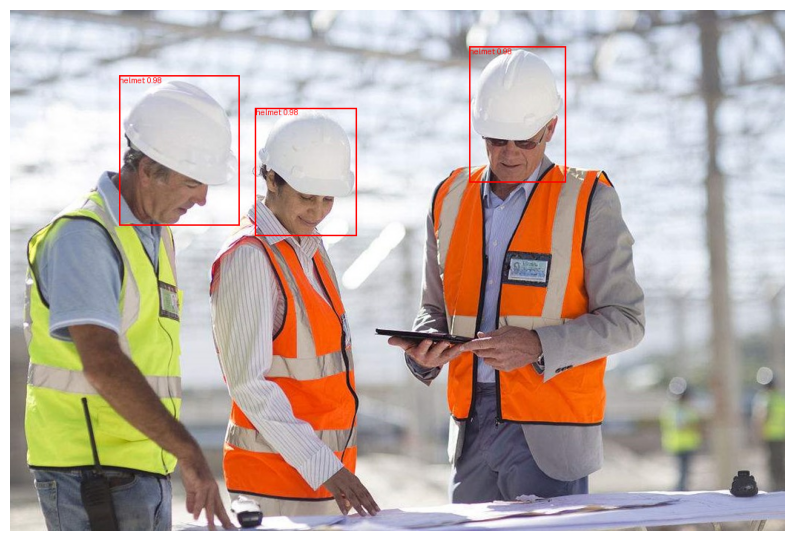

In [154]:
sample = validation_dataset[5]
plot_detr_predictions(sample["file_name"], model, processor, threshold=0.7)


In [155]:
# Generate the predictions from the model and save them to use in the XAI predictions
def generate_coco_predictions(model, processor, dataset, output_path):
  model.eval()
  model.to("cuda" if torch.cuda.is_available() else "cpu")
  results = []
  for item in tqdm(dataset):
    image_id = item["image_id"]
    image_path = item["file_name"]
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model(**inputs)
        width, height = image.size
        target_sizes = torch.tensor([[height, width]], device=model.device)

        results_batch = processor.post_process_object_detection(
            outputs, target_sizes=target_sizes, threshold=0.5
        )[0]

        for score, label, box in zip(results_batch["scores"], results_batch["labels"], results_batch["boxes"]):
            x_min, y_min, x_max, y_max = box.tolist()
            coco_box = [x_min, y_min, x_max - x_min, y_max - y_min]

            results.append({"image_id": image_id,
                "category_id": label.item(),
                "bbox": coco_box,
                "score": score.item()})
    # Save results to JSON format file
    with open(output_path, "w") as f:
        json.dump(results, f)

In [156]:
output_json = "/content/drive/MyDrive/Thesis/thesis dataset final/detr-finetuned_new/detr_predictions.json"
generate_coco_predictions(model, processor, validation_dataset, output_json)

100%|██████████| 607/607 [01:02<00:00,  9.79it/s]


✅ Saved predictions to: /content/drive/MyDrive/Thesis/thesis dataset final/detr-finetuned_new/detr_predictions.json


In [157]:
# Generating the evaluation metrics with mAP scores using COCO pycocotools
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
gt_path = "/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/COCO_new/instances_val_fixed.json"
dt_path = "/content/drive/MyDrive/Thesis/thesis dataset final/detr-finetuned_new/detr_predictions.json"
coco_gt = COCO(gt_path)
with open(dt_path) as f:
    detections = json.load(f)
coco_dt = coco_gt.loadRes(detections)
coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.75s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.481
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.787
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.486
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.598
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.171
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.429
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Deformable DETR

In [114]:
# Loading and fine tuning the DETR model from the Hugging Face
from transformers import AutoImageProcessor, DeformableDetrForObjectDetection
processor2 = AutoImageProcessor.from_pretrained("SenseTime/deformable-detr")
model2 = DeformableDetrForObjectDetection.from_pretrained("SenseTime/deformable-detr",num_labels=2,
    ignore_mismatched_sizes=True)
model2.config.id2label = {0: "helmet", 1: "person"}
model2.config.label2id = {"helmet": 0, "person": 1}

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

In [115]:
train_dataset_torch2 = DetrCocoTorchData(train_dataset, processor2)
val_dataset_torch2 = DetrCocoTorchData(validation_dataset, processor2)

In [116]:
# Setting training arguments for Deformable DETR
DeformableDETRargs = TrainingArguments(output_dir="./deformable-detr-finetuned_new",
    per_device_train_batch_size=2,
    logging_dir="./logs",
    logging_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    learning_rate=3e-5,
    remove_unused_columns=False,
    run_name="deformable_detr_run_2",
    report_to="none",
   logging_steps=500,)

trainer2 = Trainer( model=model2,
    args=DeformableDETRargs,
    train_dataset=train_dataset_torch2,
    eval_dataset=val_dataset_torch2,
    data_collator=collate_for_detr,)

In [117]:
trainer2.train()

TrainOutput(global_step=13645, training_loss=0.6884764819845869, metrics={'train_runtime': 7396.0468, 'train_samples_per_second': 3.689, 'train_steps_per_second': 1.845, 'total_flos': 2.089697657059509e+19, 'train_loss': 0.6884764819845869, 'epoch': 5.0})

In [118]:
# saving the Deformable DETR model
model2.save_pretrained("/content/drive/MyDrive/Thesis/thesis dataset final/deformable-detr-finetuned_new")
processor2.save_pretrained("/content/drive/MyDrive/Thesis/thesis dataset final/deformable-detr-finetuned_new")


['/content/drive/MyDrive/Thesis/thesis dataset final/deformable-detr-finetuned_new/preprocessor_config.json']

In [119]:
model2.save_pretrained("/content/drive/MyDrive/Thesis/thesis dataset final/deformable-detr-finetuned_new")
processor2.save_pretrained("content/drive/MyDrive/Thesis/thesis dataset final/deformable-detr-finetuned_new")


['content/drive/MyDrive/Thesis/thesis dataset final/deformable-detr-finetuned_new/preprocessor_config.json']

In [120]:
model2.save_pretrained("/content/drive/MyDrive/Thesis/thesis dataset final/deformable-detr-finetuned_new")

In [121]:
# Loading the model for later use
model_path2 = "/content/drive/MyDrive/Thesis/thesis dataset final/deformable-detr-finetuned_new"
processor2 = AutoImageProcessor.from_pretrained(model_path2)
model2 = DeformableDetrForObjectDetection.from_pretrained(model_path2, use_safetensors=True)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

In [123]:
from PIL import ImageDraw
def plot_deformable_detr_predictions(image_path, model2, processor2, threshold=0.7):
  image = Image.open(image_path).convert("RGB")
  encoding = processor2(images=image, return_tensors="pt").to(model2.device)
  with torch.no_grad():
      outputs = model2(**encoding)
  target_sizes = torch.tensor([image.size[::-1]]).to(model2.device)
  results = processor2.post_process_object_detection(outputs, threshold=threshold, target_sizes=target_sizes)[0]
    draw = ImageDraw.Draw(image)
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        draw.rectangle(box, outline="red", width=2)
        draw.text((box[0], box[1]), f"{model2.config.id2label[label.item()]}: {score:.2f}", fill="red")
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()

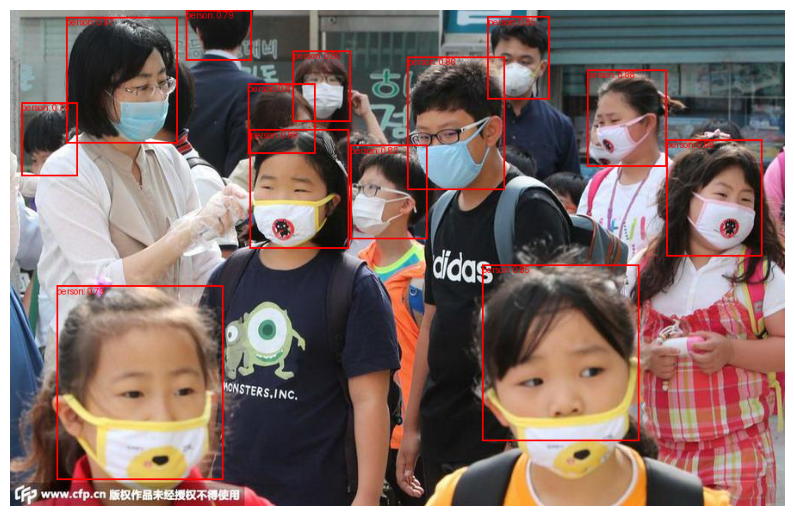

In [124]:
# Overlaying the predicted bounding box from deformable detr
image_path_pred = "/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/JPEGImages/PartB_00395.jpg"
plot_deformable_detr_predictions(image_path_pred, model2, processor2, threshold=0.7)

In [125]:
import json
import torch
from tqdm import tqdm
from PIL import Image
def generate_coco_predictions_deformable(model2, processor2, dataset, output_path):
  model2.eval()
  model2.to("cuda" if torch.cuda.is_available() else "cpu")
  results = []
  for item in tqdm(dataset):
    image_id = item["image_id"]
    image_path = item["file_name"]
    image = Image.open(image_path).convert("RGB")
     inputs = processor2(images=image, return_tensors="pt").to(model2.device)
        with torch.no_grad():
            outputs = model2(**inputs)
        width, height = image.size
        target_sizes = torch.tensor([[height, width]], device=model2.device)

        results_batch = processor2.post_process_object_detection(
            outputs, target_sizes=target_sizes, threshold=0.5
        )[0]
        for score, label, box in zip(results_batch["scores"], results_batch["labels"], results_batch["boxes"]):
            x_min, y_min, x_max, y_max = box.tolist()
            coco_box = [x_min, y_min, x_max - x_min, y_max - y_min]
            results.append({"image_id": image_id,
                "category_id": label.item(),
                "bbox": coco_box,
                "score": score.item()})
    with open(output_path, "w") as f:
        json.dump(results, f)

In [126]:
output_json1 = "/content/drive/MyDrive/Thesis/thesis dataset final/deformable-detr-finetuned_new/deformable_detr_predictions.json"
generate_coco_predictions_deformable(model2, processor2, validation_dataset, output_json1)

100%|██████████| 607/607 [01:23<00:00,  7.24it/s]


✅ Saved predictions to: /content/drive/MyDrive/Thesis/thesis dataset final/deformable-detr-finetuned_new/deformable_detr_predictions.json


In [127]:
# Evaluating the Deformable DETR model
gt_path1 = "/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/COCO_new/instances_val_fixed.json"
dt_path1 = "/content/drive/MyDrive/Thesis/thesis dataset final/deformable-detr-finetuned_new/deformable_detr_predictions.json"
coco_gt_deformable1 = COCO(gt_path1)
with open(dt_path1) as f:
    detections = json.load(f)
coco_dt_deformable1 = coco_gt_deformable1.loadRes(detections)
coco_eval = COCOeval(coco_gt_deformable1, coco_dt_deformable1, iouType="bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=6.20s).
Accumulating evaluation results...
DONE (t=0.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.535
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.809
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.575
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.362
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.623
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.725
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.443
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [ ]:
# Fix the JSON in place
with open("/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/COCO_new/instances_val.json") as f:
    coco_data = json.load(f)
if "info" not in coco_data:
    coco_data["info"] = {"description": "Manually added dummy info to avoid pycocotools KeyError"}
with open("/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/COCO_new/instances_val_fixed.json", "w") as f:
    json.dump(coco_data, f)

EXPLAINABLE AI GRAD-CAM

In [255]:
# Installing necessary libraries for grad cam and version
!pip install grad-cam

In [256]:
from pytorch_grad_cam import EigenCAM, GradCAM

In [257]:
model.model.backbone
print(model.model.backbone)

DetrConvModel(
  (conv_encoder): DetrConvEncoder(
    (model): FeatureListNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): DetrFrozenBatchNorm2d()
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): DetrFrozenBatchNorm2d()
          (drop_block): Identity()
          (act2): ReLU(inplace=True)
          (aa): Identity()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): DetrFrozenBatchNorm2d()
          (act3): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2

**Grad-CAM visualisation**

In [258]:
# Imports for Grad CAM
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import torch.nn as nn

In [259]:
# Loading the DETR saved model and precessor with cuda
model = DetrForObjectDetection.from_pretrained(model_path).eval().to("cuda")

In [260]:
# loading the image, resizing and normalizing it
image_path1 = "/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/JPEGImages/000147.jpg"
image_grad = Image.open(image_path1).convert("RGB")
image_grad = image_grad.resize((512, 512))
img_arr = np.array(image_grad, dtype=np.float32) / 255.0

# Send through processor
inputs = processor(images=image_grad, return_tensors="pt", do_resize=False).to("cuda")
height_grad, width_grad = inputs["pixel_values"].shape[-2:]

In [261]:
# Checking and printing the top class id and top scoring class and confidence score of that class
with torch.no_grad():
    outputs_grad = model(**inputs)
    probs_grad = outputs_grad.logits.softmax(-1)[0, :, :-1]
confidence_grad, labels_grad = probs_grad.max(-1)
top_idx_grad = confidence_grad.argmax().item()
top_label_grad = labels_grad[top_idx_grad].item()
top_score_grad = confidence_grad[top_idx_grad].item()
print(f"class {top_label_grad}, query {top_idx_grad}, score={top_score_grad:.2f}")

class 0, query 58, score=0.99


In [262]:
# Customer wrapper class to compute Grad Cam for object prediction
class GradCamDETRWrapper(nn.Module):
 def __init__(self, model, cls_id, query_idx):
  super().__init__()
  self.model = model
  self.cls_id = cls_id
  self.query_idx = query_idx
 def forward(self, x):
    out = self.model(x)
    score = out.logits[0, self.query_idx, self.cls_id]
    return score.unsqueeze(0).unsqueeze(0)
wrapped_model_grad = GradCamDETRWrapper(model, cls_id=top_label_grad, query_idx=top_idx_grad)


Number of Grad-CAM highlighted pixels: 74592 (thr=0.353)
Example coords (row, col): [[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [0 6]
 [0 7]
 [0 8]
 [0 9]]


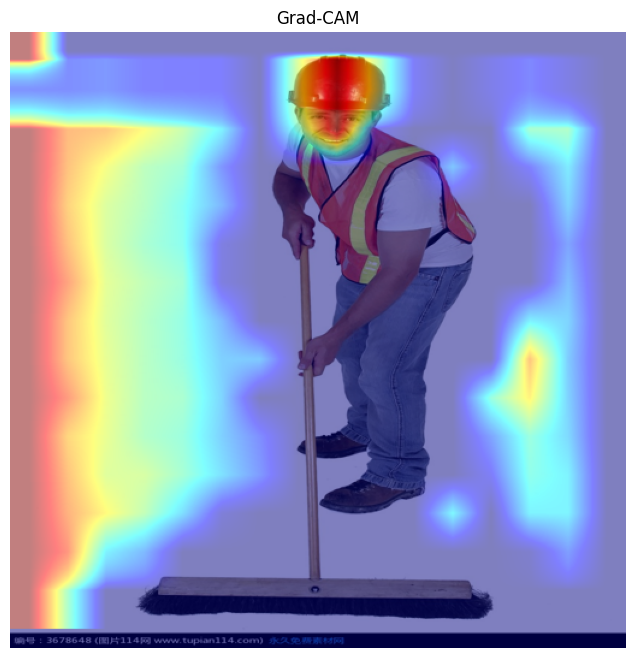

In [263]:
# Grad-CAM setup
target_layers = [model.model.backbone.conv_encoder.model.layer4[-1]]
cam = GradCAM(model=wrapped_model_grad, target_layers=target_layers)
with cam:
    cam_gray_raw_grad = cam(input_tensor=inputs["pixel_values"],
                            targets=[ClassifierOutputTarget(0)])[0]
    cam_gray_grad = scale_cam_image(cam_gray_raw_grad)

# Resize CAM to input size and normalise
cam_heatmap = cv2.resize(cam_gray_grad, (width_grad, height_grad), interpolation=cv2.INTER_CUBIC)
cam_heatmap = (cam_heatmap - cam_heatmap.min()) / (np.ptp(cam_heatmap) + 1e-8)

#Threshold (Otsu) to find most scoring highlighted pixels
cam_u8 = (cam_heatmap * 255).astype(np.uint8)
threshols_val, _ = cv2.threshold(cam_u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
threshold_grad = threshols_val / 255.0
gradcam_mask = (cam_heatmap >= threshold_grad).astype(np.uint8)
gradcam_coords_new = np.column_stack(np.where(gradcam_mask == 1))  # (row, col)
print(f"Number of Grad-CAM highlighted pixels: {int(gradcam_mask.sum())} (thr={threshold_grad:.3f})")
print("Example coords (row, col):", gradcam_coords_new[:10])
np.save("gradcam_coords_new.npy", gradcam_coords_new)
np.save("gradcam_mask.npy", gradcam_mask)
np.save("gradcam_threshold.npy", np.array([threshold_grad], dtype=np.float32))
cam_overlay = show_cam_on_image(img_arr, cam_heatmap, use_rgb=True)
plt.figure(figsize=(8, 8))
plt.imshow(cam_overlay)
plt.axis("off")
plt.title("Grad-CAM")
plt.show()

**Cross Attention Visualisation**

In [264]:
# Loading model with output_attention=True, to get the attention weights
model = DetrForObjectDetection.from_pretrained(model_path, output_attentions=True).eval().cpu()
processor = DetrImageProcessor.from_pretrained(model_path)

#Load, resize and normalise the image
image_path = "/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/JPEGImages/000147.jpg"
image = Image.open(image_path).convert("RGB").resize((512, 512))
img_arr = np.array(image).astype(np.float32) / 255.0
inputs = processor(images=image, return_tensors="pt", do_resize=False)

# Forward pass through the model
with torch.no_grad():
    outputs = model(**inputs)

# Again to see top query in the prediction and choose that
attn_maps = outputs.cross_attentions[-1][0]
attn_avg  = attn_maps.mean(0)
logits    = outputs.logits.softmax(-1)[0, :, :-1]
top_idx_attn   = logits.max(dim=-1).values.argmax().item()
attn      = attn_avg[top_idx_attn][1:]

Number of attention highlighted pixels: 11244 (thr=0.271)
Example coords: [[  0 211]
 [  0 212]
 [  0 213]
 [  0 214]
 [  0 215]
 [  0 216]
 [  0 217]
 [  0 218]
 [  0 219]
 [  0 220]]


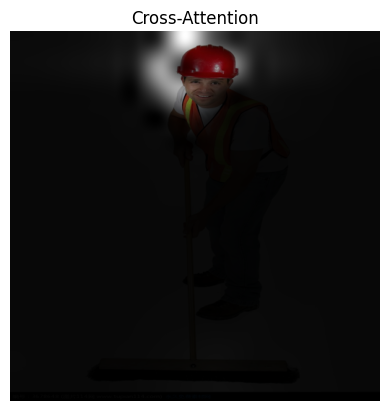

In [267]:
#Reshape to the TRUE DETR grid (stride=32)
Height_attn, Width_attn = inputs['pixel_values'].shape[-2:]
grid_h, grid_w = Height_attn // 32, Width_attn // 32
tokens = attn.numel()
target = grid_h * grid_w
if tokens < target:
    attn = torch.cat([attn, torch.zeros(target - tokens)], dim=0)
elif tokens > target:
    attn = attn[:target]

attn_grid = attn.reshape(grid_h, grid_w).cpu().numpy()
attntion_map  = cv2.resize(attn_grid, (Width_attn, Height_attn), interpolation=cv2.INTER_CUBIC)
attntion_map  = (attntion_map - attntion_map.min()) / (np.ptp(attntion_map) + 1e-8)

# Highlighted pixels using Otsu threshold anx extract
attn_u8 = (attntion_map * 255).astype(np.uint8)
threshols_u8, _ = cv2.threshold(attn_u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
thr = threshols_u8 / 255.0

mask = (attn_map >= thr).astype(np.uint8)
highlight_pixels_new = np.column_stack(np.where(mask == 1))
print(f"Number of attention highlighted pixels: {int(mask.sum())} (thr={thr:.3f})")
print("Example coords:", highlight_pixels_new[:10])
heatmap = (attntion_map[..., None] * img_arr).clip(0, 1)
plt.imshow(heatmap)
plt.axis("off")
plt.title("Cross-Attention")
plt.show()
np.save("attn_map.npy", attntion_map)
np.save("attn_mask.npy", mask)
np.save("highlight_pixels_new.npy", highlight_pixels_new)
np.save("attention_shape.npy", np.array([Height_attn, Width_attn], dtype=np.int32))

In [275]:
# Loading the attention and grad cam output files
helmet_attn_mask   = np.load("attn_mask.npy")
helmet_attn_coords = np.load("highlight_pixels_new.npy")
helmet_grad_mask   = np.load("gradcam_mask.npy")
helmet_grad_coords = np.load("gradcam_coords_new.npy")
# Checking if they are in same size or else overlap cannot be studied peroperly
Ha, Wa = helmet_attn_mask.shape
Hg, Wg = helmet_grad_mask.shape
if (Ha, Wa) != (Hg, Wg):
    helmet_grad_mask = cv2.resize(helmet_grad_mask.astype(np.uint8), (Wa, Ha), interpolation=cv2.INTER_NEAREST)
    helmet_grad_coords = np.column_stack(np.where(helmet_grad_mask == 1))
# Membership check
in_grad_pixels = helmet_grad_mask[helmet_attn_coords[:,0], helmet_attn_coords[:,1]].astype(bool)
num_attn = helmet_attn_coords.shape[0]
num_grad = int(helmet_grad_mask.sum())
num_overlap = int(in_grad_pixels.sum())
print(f"Attention pixels: {num_attn}")
print(f"Grad-CAM pixels : {num_grad}")
print(f"Overlap pixels  : {num_overlap}")

# Intersection over union
attn_boolean = helmet_attn_mask.astype(bool)
grad_boolean = helmet_grad_mask.astype(bool)
iou = np.logical_and(attn_boolean, grad_boolean).sum() / (np.logical_or(attn_boolean, grad_boolean).sum() + 1e-8)
print(f"IoU: {iou:.4f}")

Attention pixels: 11244
Grad-CAM pixels : 74592
Overlap pixels  : 5694
IoU: 0.0710


In [279]:
# For showing overlap between Grad Cam and Cross attention
# Load masks and coordinate files
mask_attn = np.load("attn_mask.npy")
coords_attn = np.load("highlight_pixels_new.npy")
mask_grad = np.load("gradcam_mask.npy")
coords_grad = np.load("gradcam_coords_new.npy")
print("Loaded shapes -> mask_attn:", mask_attn.shape, "mask_grad:", mask_grad.shape)
# Ensure both masks are same size
h_a, w_a = mask_attn.shape
h_g, w_g = mask_grad.shape
if (h_a, w_a) != (h_g, w_g):
    mask_grad = cv2.resize(mask_grad.astype(np.uint8), (w_a, h_a), interpolation=cv2.INTER_NEAREST)
    coords_grad = np.column_stack(np.where(mask_grad == 1))
    print("Resized mask_grad to:", mask_grad.shape)

# Membership check: attention coords inside grad-cam mask
inside_grad_flags = mask_grad[coords_attn[:, 0], coords_attn[:, 1]].astype(bool)
n_attn_coords = coords_attn.shape[0]
n_grad_pixels = int(mask_grad.sum())
n_both_coords = int(inside_grad_flags.sum())
perc_attn_in_grad = (n_both_coords / n_attn_coords * 100) if n_attn_coords > 0 else 0
perc_grad_in_attn = (n_both_coords / n_grad_pixels * 100) if n_grad_pixels > 0 else 0

print(f"\nMembership (coords):")
print(f"  {n_both_coords} / {n_attn_coords} attention coords in Grad-CAM ({perc_attn_in_grad:.2f}%)")
print(f"  {n_both_coords} / {n_grad_pixels} Grad-CAM coords in Attention ({perc_grad_in_attn:.2f}%)")
bool_attn = mask_attn.astype(bool)
bool_grad = mask_grad.astype(bool)
n_intersection = np.logical_and(bool_attn, bool_grad).sum()
n_union        = np.logical_or(bool_attn, bool_grad).sum()
n_attn_pixels  = bool_attn.sum()
n_grad_pixels  = bool_grad.sum()
iou_score   = n_intersection / (n_union + 1e-8)
precision   = n_intersection / (n_attn_pixels + 1e-8)
recall      = n_intersection / (n_grad_pixels + 1e-8)
dice_coeff  = 2 * n_intersection / (n_attn_pixels + n_grad_pixels + 1e-8)
print("\nMask overlap metrics:")
print(f"  attention pixels: {n_attn_pixels} ({n_attn_pixels / (h_a*w_a) * 100:.2f}% of image)")
print(f"  grad-cam pixels : {n_grad_pixels} ({n_grad_pixels / (h_a*w_a) * 100:.2f}% of image)")
print(f"  intersection    : {n_intersection} ({n_intersection / (h_a*w_a) * 100:.2f}% of image)")
print(f"  union           : {n_union} ({n_union / (h_a*w_a) * 100:.2f}% of image)")
print(f"  IoU             : {iou_score:.4f}")
print(f"  Precision(attn→grad): {precision:.4f} ({precision*100:.2f}%)")
print(f"  Recall(attn→grad)   : {recall:.4f} ({recall*100:.2f}%)")
print(f"  Dice coefficient    : {dice_coeff:.4f} ({dice_coeff*100:.2f}%)")
coords_attn_in_grad  = coords_attn[inside_grad_flags]
coords_attn_not_grad = coords_attn[~inside_grad_flags]
print("\nExamples (row, col):")
print("  First 10 attn ∩ grad:", coords_attn_in_grad[:10])
print("  First 10 attn-only   :", coords_attn_not_grad[:10])
vis_overlap = np.zeros((h_a, w_a, 3), dtype=np.uint8)
vis_overlap[bool_attn & ~bool_grad] = (0, 255, 0)     # green = attention only
vis_overlap[~bool_attn & bool_grad] = (255, 0, 0)     # red   = grad-cam only
vis_overlap[bool_attn & bool_grad]  = (255, 255, 0)   # yellow= overlap
cv2.imwrite("overlap_vis.png", cv2.cvtColor(vis_overlap, cv2.COLOR_RGB2BGR))
print("\nSaved overlap visualization: overlap_vis.png")

Loaded shapes -> mask_attn: (512, 512) mask_grad: (512, 512)

Membership (coords):
  5694 / 11244 attention coords in Grad-CAM (50.64%)
  5694 / 74592 Grad-CAM coords in Attention (7.63%)

Mask overlap metrics:
  attention pixels: 11244 (4.29% of image)
  grad-cam pixels : 74592 (28.45% of image)
  intersection    : 5694 (2.17% of image)
  union           : 80142 (30.57% of image)
  IoU             : 0.0710
  Precision(attn→grad): 0.5064 (50.64%)
  Recall(attn→grad)   : 0.0763 (7.63%)
  Dice coefficient    : 0.1327 (13.27%)

Examples (row, col):
  First 10 attn ∩ grad: [[ 18 271]
 [ 18 272]
 [ 19 249]
 [ 19 250]
 [ 19 251]
 [ 19 252]
 [ 19 253]
 [ 19 254]
 [ 19 255]
 [ 19 256]]
  First 10 attn-only   : [[  0 211]
 [  0 212]
 [  0 213]
 [  0 214]
 [  0 215]
 [  0 216]
 [  0 217]
 [  0 218]
 [  0 219]
 [  0 220]]

Saved overlap visualization: overlap_vis.png


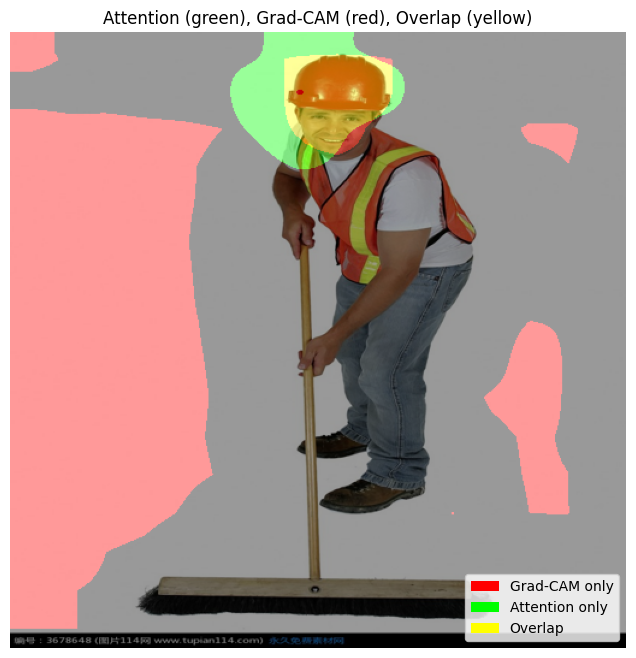

In [281]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# making sure masks match the image size
H_img, W_img = img_arr.shape[:2]

A = attn_mask.astype(np.uint8)
G = gradcam_mask.astype(np.uint8)

if A.shape != (H_img, W_img):
    A = cv2.resize(A, (W_img, H_img), interpolation=cv2.INTER_NEAREST)
if G.shape != (H_img, W_img):
    G = cv2.resize(G, (W_img, H_img), interpolation=cv2.INTER_NEAREST)
overlay = np.zeros_like(img_arr, dtype=np.float32)
attention_only = (A == 1) & (G == 0)
gradcam_only   = (A == 0) & (G == 1)
overlap        = (A == 1) & (G == 1)
overlay[attention_only] = [0.0, 1.0, 0.0]
overlay[gradcam_only]   = [1.0, 0.0, 0.0]
overlay[overlap]        = [1.0, 1.0, 0.0]
alpha = 0.40
blend = (1 - alpha) * img_arr.astype(np.float32) + alpha * overlay
blend = np.clip(blend, 0, 1)
plt.figure(figsize=(8, 8))
plt.imshow(blend)
plt.axis("off")
plt.title("Attention (green), Grad-CAM (red), Overlap (yellow)")
legend_elems = [
    Patch(facecolor='red',   edgecolor='none', label='Grad-CAM only'),
    Patch(facecolor='lime',  edgecolor='none', label='Attention only'),
    Patch(facecolor='yellow',edgecolor='none', label='Overlap'),
]
plt.legend(handles=legend_elems, loc='lower right', frameon=True)


SHAP output

  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [09:56, 596.33s/it]              


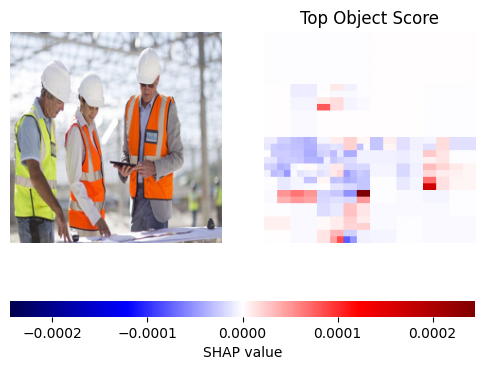

In [273]:
# Load and preprocess image
image_path = "/content/drive/MyDrive/Thesis/thesis dataset final/Dataset/JPEGImages/000035.jpg"
image = Image.open(image_path).convert("RGB").resize((224, 224))
img_np = np.array(image, dtype=np.float32) / 255.0
def wrapped_model(imgs):
  changes = [Image.fromarray((img * 255).astype(np.uint8)) for img in imgs]
  inputs = processor(images=changes, return_tensors="pt")
  with torch.no_grad():
        outputs = model(**inputs)
  logits = outputs.logits.softmax(-1)[..., :-1]
  top_scores = logits.max(dim=-1).values.max(dim=-1).values

  return top_scores.unsqueeze(-1).numpy()
masker_helmet = shap.maskers.Image("inpaint_telea", img_np.shape)
explainer_shap = shap.Explainer(wrapped_model, masker_helmet, output_names=["Top Object Score"])
shap_values_pred = explainer_shap(np.expand_dims(img_np, axis=0), max_evals=1000, batch_size=1)
shap.image_plot(shap_values_pred, np.expand_dims(img_np, axis=0), cmap="seismic")